In [1]:
from unityagents import UnityEnvironment
import numpy as np

import gym

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
# please do not modify the line below
env = UnityEnvironment(file_name="Banana.app")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
class Qnetwork(nn.Module):
    def __init__(self,state_size,action_size):
        # initialising the super class properties
        super(Qnetwork,self).__init__()
        
        # defining layers
        self.fc1 = nn.Linear(state_size,32)
        self.fc2 = nn.Linear(32,64)
        self.fc3 = nn.Linear(64,128)
        self.out = nn.Linear(128,action_size)
        
    def forward(self,states):
        x = F.relu(self.fc1(states))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        out = F.relu(self.out(x))
        return out

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from collections import deque,namedtuple

class ReplayBuffer:
    def __init__(self,buffer_size,batch_size):
        self.buffer = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.batch_size = batch_size
        
    def add(self,state,action,reward,next_state,done):
        e = self.experience(state,action,reward,next_state,done)
        self.buffer.append(e)
    
    def sample(self,random=True):
        if random:
            choose = np.random.choice(range(len(self.buffer)),self.batch_size,replace=False)
            experiences = [self.buffer[i] for i in choose]
        else:
            pass
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states,actions,rewards,next_states,dones)
    
    def __len__(self):
        return len(self.buffer)

In [6]:
UPDATE_EVERY = 4
class Agent:
    def __init__(self,state_size,action_size,gamma=0.99,lr=5e-4,
                     buffer_size=int(1e5),batch_size=64,tau=1e-3):
        # defining local and target networks
        self.qnet_local = Qnetwork(state_size,action_size).to(device)
        self.qnet_target = Qnetwork(state_size,action_size).to(device)
        
        # set local and target parameters equal to each other
        self.soft_update(tau=1.0)
        
        # experience replay buffer
        self.memory = ReplayBuffer(buffer_size,batch_size)
        
        # defining variables
        self.state_size = state_size
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        self.tau = tau
        
        self.t_step = 0
        
        # optimizer
        self.optimizer = optim.Adam(self.qnet_local.parameters(),lr=self.lr)
    
    def step(self,state,action,reward,next_state,done):
        """ saves the step info in the memory buffer and perform a learning iteration
        Input : 
            state,action,reward,state,done : non-batched numpy arrays
        
        Output : 
            none
        """
        # add sample to the memory buffer
        self.memory.add(state,action,reward,next_state,done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        
        # use replay buffer to learn if it has enough samples
        if self.t_step == 0:
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)
        
    def learn(self,experiences):
        """ perform a learning iteration by using sampled experience batch
        Input : 
            experience : tuple from the memory buffer
            states, actions, rewards, next_states, dones = experiences
            eg : states.shape = [N,state_size]
        Output : 
            none
        """
        states, actions, rewards, next_states, dones = experiences
        
        # set optimizer grdient to zero
        self.optimizer.zero_grad()
        
        # predicted action value
        q_pred = self.qnet_local.forward(states).gather(1,actions)
        
        # target action value
        q_target = rewards + self.gamma*(1-dones)*self.qnet_target.forward(next_states).detach().max(1)[0].unsqueeze(1)
        
        # defining loss
        loss = F.mse_loss(q_pred,q_target)
        
        # running backprop and optimizer step
        loss.backward()
        self.optimizer.step()
        
        # run soft update
        self.soft_update(self.tau)
        
    def act(self,state,eps=0.):
        """ return the local model's predicted action for the given state
        Input : 
            state : [state_size]
        
        Output : 
            action : scalar action as action space is discrete with dim = 1
        """
        state = torch.from_numpy(state).float().to(device) # converts numpy array to torch tensor
        
        self.qnet_local.eval() # put net in test mode
        with torch.no_grad():
            max_action = np.argmax(self.qnet_local(state).cpu().data.numpy())
        self.qnet_local.train() # put net back in train mode
        
        rand_num = np.random.rand() # sample a random number uniformly between 0 and 1
        
        # implementing epsilon greedy policy
        if rand_num < eps:
            return np.random.randint(self.action_size)
        else: 
            return max_action
        
    def soft_update(self,tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        """
        for target_param, local_param in zip(self.qnet_target.parameters(), self.qnet_local.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [7]:
agent = Agent(state_size=brain.vector_observation_space_size, action_size=brain.vector_action_space_size)

def dqn_train(max_episodes=1000,max_t=1000,eps_start=1.0,eps_end=1e-2,eps_decay=.995):
        eps = eps_start
        scores = []
        score_window = deque(maxlen=100)
        avg_scores = []
        
        for episode_count in range(max_episodes):
            
            # reset env state
            env_info = env.reset(train_mode=True)[brain_name]
            state = env_info.vector_observations[0]
            
            done = env_info.local_done[0]
            total_reward = 0
            for t in range(max_t):
                # choose action using the local q-network
                action = agent.act(state,eps)

                # taking action in the env
                env_info = env.step(vector_action=action)[brain_name]

                # getting next_state,reward,done from the env
                next_state = env_info.vector_observations[0]
                reward = env_info.rewards[0]
                done = env_info.local_done[0]
                
                # using agent to perform a learning step and save the sample in the memory
                agent.step(state,action,reward,next_state,done)
                
                # decay the epsilon value
                eps = max(eps_decay*eps,eps_end)
                
                # get total reward for the episode
                total_reward += reward
                
                # set current state = next_state
                state = next_state
                
                if done:
                    break
                
            scores.append(total_reward)
            score_window.append(total_reward)
            avg_scores.append(np.mean(score_window))

            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode_count, np.mean(score_window)), end="")
            if episode_count % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode_count, np.mean(score_window)))
            
            if np.mean(score_window) > 13:
                print('\rLearning completed in {} episodes ... avg_score :{}'.format(episode_count, np.mean(score_window)))
                break
                
        return scores,avg_scores

In [8]:
scores,avg_scores = dqn_train(max_episodes=500)

Episode 0	Average Score: -1.00
Episode 100	Average Score: 2.06
Episode 200	Average Score: 9.12
Episode 300	Average Score: 12.31
Learning completed in 367 episodes ... avg_score :13.08


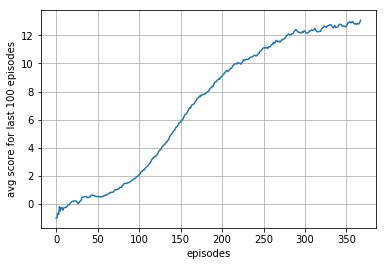

In [9]:
plt.plot(range(len(avg_scores)),avg_scores)
plt.xlabel('episodes')
plt.ylabel('avg score for last 100 episodes')
plt.grid()
plt.show()

In [10]:
env.close()